
## Compare Pytorch, ONNX, and CoreML Resnet50 Models

This notebook compares the predictions of six Resnet50 Models. It loads the original, intermediate and final models created by the conversions described in the previous Notebooks and compares the results for agreement. These models are named:

- **torchm** - Torch model from the torchvision distribution
- **t2o**    - An ONNX Model. The result of converting **torchm** to ONNX. The intermediate stage of conversion to CoreML
- **t2c**    - A CoreML Model. The result of convering the intermediate model **t2o** to CoreML.

( The three models above are sometimes called the *"Torch Family"* )
    
- **onnxm**  - The ONNX Resnet50 model from the ONNX Model Zoo on Github
- **o2c**    - A CoreML Model. The result of converting **onnxm** to CoreML.

( The two models above are sometimes called the *"ONNX Family"* )
        
- **cml**    - A CoreML Model. For the comparisons, I added the "native" CoreML Resnet50 model from the CoreML Model Zoo (Its an orphan)

This has become a long notebook.  Here is how it unfolds, in case you want to skip sections:

- Set test parameters, specify locations of test images
- Load and check the six models: ONNX, O2C, Torch, T2O, T2C, and CML (CoreML) (starts ~ cell 10)
- Generate Predictions for each image using all models (~ cell 30)
- Check - show a small selection of results (~ cell 34 )
- Analyze how much agreement there was between models, create the Agreement Matrix (~ cell 35)
- Wrap up - Show some more results. (~ cell 50)


### Links

> [10-Intro-resnet50-convert-compare](10-Intro-resnet50-convert-compare.ipynb) - Intro notebook, contains context and discussion.   
>
> [coreml_help](https://mcsieber.github.io/coreml_help.html) - Documentation for helper module   
>
> [pred_help](https://mcsieber.github.io/pred_help.html) - - - Documentation for helper module  


### Summary
If you don't want to wade thru all this (I don't blame you), here are the results:

>The *Torch Family* (*Torch -> t2o -> t2c*) seems to produce very consistent results. Their predictions agree about 95% of the time. That is good news, because ultimately I'd like to port a Torch Resnet50 Model of my own creation to CoreML.

>The *ONNX Family*  (*ONNX -> o2c*) predictions agree only about 60% of the time. A little surprising, that. 

>The native CoreML, ONNX and Torch models agree with each other about 50% of the time.

There is a full color-mapped **Agreement Matrix** in the *Agreement* sections, near the end.


#### Agreement Matrix

Here's the Agreement Matrix. Because it requires a lot of data and variables that do not exist until the entire notebook is run once, run the cell below ***only*** after doing that.

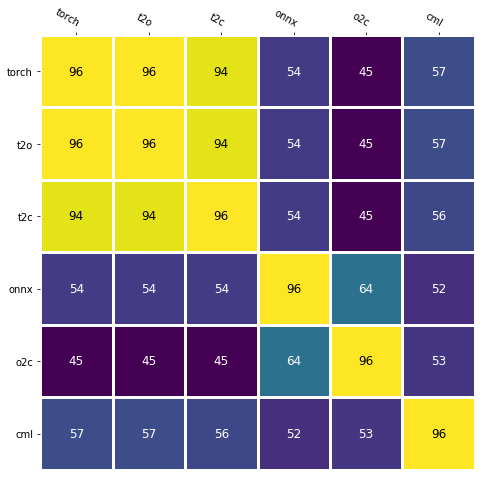

In [47]:
results.agree_matrix()

The cell below is common setup for this and other notebooks. You do have to run it, but you can ignore it otherwise.

In [2]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')

%reload_ext autoreload
%autoreload 0
%matplotlib inline

import numpy as np
from   pathlib import Path
# mcs utilities and helpers
from   ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'compare'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

# %run -i {user_lib}/finish_setup.py [--show [Proj Paths Env] | None | All ] 
#
%run -i {user_lib}/finish_setup.py --show Proj

data_root       =  /Volumes/ArielD/storage
data_dir        =  /Volumes/ArielD/storage/data
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
project_name    =  compare
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
proj_dir        =  /Users/mcsieber/storage/notebooks/compare
model_name      =  resnet50
model_arch      =  Resnet50
models_dir      =  /Volumes/ArielD/storage/data/compare/models
img_size        =  300
batch_size      =  32



## Additional Setup

In [3]:
from PIL import Image
from PIL import ImageOps
from pred_help import *
from coreml_help import *
mlmodels_dir = data_dir/'mlmodels'  # Where to find downloaded CoreML models
resize_method = Image.NEAREST       # How to resample images when they are resized

**Test Data** - Specify locations for test and validation images

In [4]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'

In [5]:
dogcat_dir    = test_root/'dogscats/large/valid-large'
flowers_dir   = test_root/'flowers/data'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
pp((dogcat_dir, flowers_dir, food_dir,fruit_dir))

dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
flowers_dir    =  PosixPath('/Volumes/ArielD/storage/data/flowers/data')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


**Test Data** - Get random images from various test image sets

In [6]:
img_per_dir = 18     # Get this many images per directory
max_sample  = 400    # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=int(img_per_dir*3), search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=img_per_dir, search_limit=max_sample)
t2 = get_rand_images(flowers_dir,n_images=img_per_dir, search_limit=max_sample)
t3 = get_rand_images(fruit_dir,  n_images=img_per_dir, search_limit=max_sample)
test_imgs = t0+t1+t2+t3
#
f"{len(test_imgs)} test images"

'96 test images'

Get validation images to sanity check the models as we load them

In [7]:
vimg_path  = Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg')
vimg300    = ImageOps.fit(Image.open(vimg_path),(300,300), method=resize_method, centering=(0.5,0.4))
vimg224    = ImageOps.fit(Image.open(vimg_path),(224,224), method=resize_method, centering=(0.5,0.4))

**Class Labels** - Load the class labels from a disk file .These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet. 

In [8]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]

**Normalization for ImageNet** - Calculate Scale and Bias for ONNX and CoreML models

As recommended, input images for the ONNX model are normalized
using the mean and standard deviation for **ImageNet**.
(For details, see Help or Notes for `imagenet_normalize`):

For the CoreML models, we use the values above to calculate an *image scale*
and (Red, Green, Blue) *channel biases* that acheive the same effect.

In [9]:
# Values for ONNX ImageNet normalization
mean = np.array(imagenet.mean)
std  = np.array(imagenet.std)

# For CoreML from ONNX, calculate scale and bias to reproduce normalization
ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

### ONNX
Load [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model and check that it works. This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [10]:
import onnx
import onnxruntime as ort

In [11]:
onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path

PosixPath('/Volumes/ArielD/storage/data/onnx/resnet50v2/resnet50.onnx')

In [12]:
onnxm = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

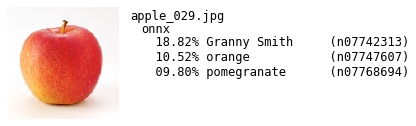

In [13]:
onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())
pred     = pred_for_onnx(onnx_rt,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='onnx');

### O2C 
O2C - Load and check the CoreML model converted from the ONNX above

In [14]:
import coremltools.models as cm

In [15]:
o2c_name = 'o2c.mlmodel'
o2c_path = models_dir/o2c_name ; o2c_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/o2c.mlmodel')

In [16]:
o2c  = cm.MLModel(o2c_path.as_posix())

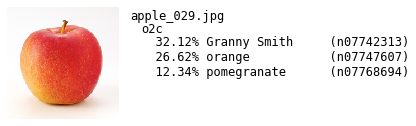

In [17]:
pred = pred_for_o2c(o2c,vimg224,labels=inet_labels)
show_pred(vimg_path, pred, model_id='o2c');

### Torch
Load and check a standard Torch Resnet50

In [18]:
import torch
import torchvision

In [19]:
torchm_name = 'torch.pth'
torchm_path = models_dir/torchm_name

In [20]:
torchm = torchvision.models.resnet50(pretrained=True)
torchm.eval()  # Must set to evaluation mode to generate predictions
labels = inet_labels

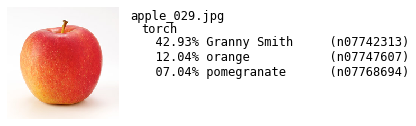

In [21]:
pred = pred_for_torch(torchm,vimg300,labels=inet_labels)
show_pred(vimg_path,pred, model_id='torch');

### T2O
T2O - Load and check ONNX model converted from Torch. This model is the intermediate stage of the *Torch->ONNX-CoreML* conversion process.

In [22]:
# T2O - Torch to Onnx
t2o_name = 't2o.onnx'
t2o_path = models_dir/t2o_name

In [23]:
t2o = onnx.load(t2o_path)
onnx.checker.check_model(t2o)

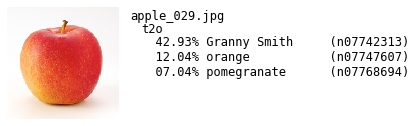

In [24]:
t2o_rt  = ort.InferenceSession(t2o_path.as_posix())
pred = pred_for_onnx(t2o_rt,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='t2o');

### T2C
T2C - Load and check the *repaired* CoreML model converted from Torch via ONNX.

In [25]:
t2c_name = 't2c.mlmodel'
t2c_path = models_dir/t2c_name

In [26]:
t2c  = cm.MLModel(t2c_path.as_posix())

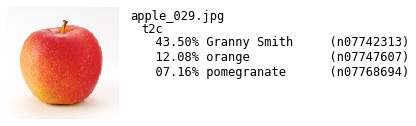

In [27]:
pred = pred_for_o2c(t2c,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='t2c');

### CoreML
CML - Load and check a standard CoreML Resnet50 model

In [28]:
coreml_name = 'Resnet50.mlmodel'
coreml_path = mlmodels_dir/'Resnet50'/coreml_name

In [29]:
cml = cm.MLModel(coreml_path.as_posix())

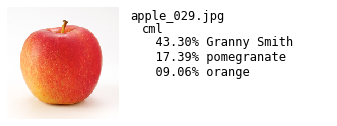

In [30]:
pred = pred_for_coreml(cml,vimg224)
show_pred(vimg_path,pred, model_id='cml');

## Predict and Compare

Specify the models to be included in the results and the parameters needed to run them.    
Create a [**Classifier**](https://mcsieber.github.io/pred_help.html#pred_help.Classifier) that uses the models we've instantiated.  
Generate a prediction from each of the models for every image. Save the results and compare.  .

In [31]:
params = { 
    'torch': PredParams( runtime=torchm,  func=pred_for_torch, labels=inet_labels, imgsize=300 ),
    't2o'  : PredParams( runtime=t2o_rt,  func=pred_for_onnx,  labels=inet_labels, imgsize=300 ),
    't2c'  : PredParams( runtime=t2c,     func=pred_for_o2c,   labels=inet_labels, imgsize=300 ),
    'onnx' : PredParams( runtime=onnx_rt, func=pred_for_onnx, labels=inet_labels, imgsize=300 ),
    'o2c'  : PredParams( runtime=o2c,     func=pred_for_o2c,   labels=inet_labels, imgsize=224 ),
    'cml'  : PredParams( runtime=cml,     func=pred_for_coreml,labels=None,        imgsize=224 ),   
    # additional models would go here
}

In [33]:
classifier = Classifier(params, top_count=3, resize_method=Image.NEAREST)

**Predictions** - Classify the images and capture the 'top_count' predictions made by each model for each image

In [34]:
classifier.classify(test_imgs);

0 of 96 processed, most recent is roots_100.jpg
Converting 00000041.jpg to RGB from RGBA 
Converting 00000014.png to RGB from RGBA 
24 of 96 processed, most recent is chick_151.jpg
Converting chick_147.png to RGB from RGBA 
Converting pasta_085.png to RGB from RGBA 
48 of 96 processed, most recent is burger_054.jpg
72 of 96 processed, most recent is 14494590921_3bb1dc7b88_n.jpg
Total of 96 images processed


**Check Results** - To see what we have, lets look at a few results before we start comparison and agreement calculations


Showing results [39, 82, 85] 
  and top 2 probabilities for each model


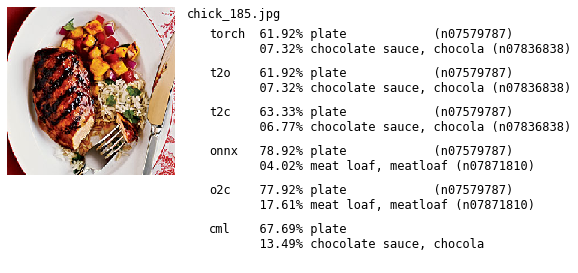

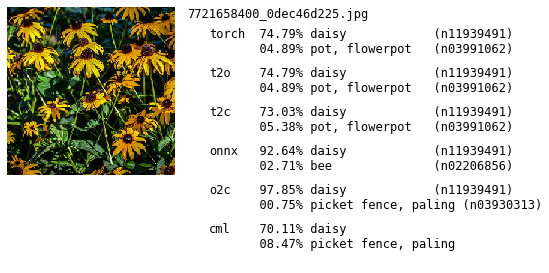

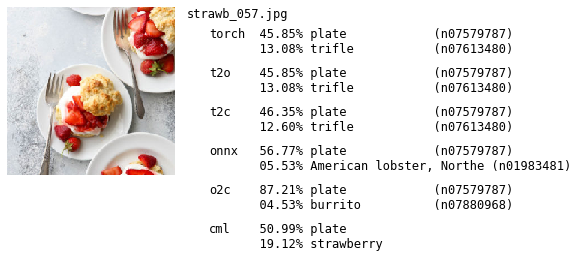

In [36]:
results = Results(classifier, pred2show=2)
results.show_random(3)

## Certainty?
Here are the most and least certain predictions for each model

torch - Most and Least Certain


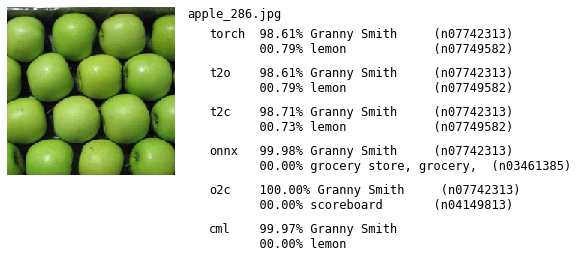

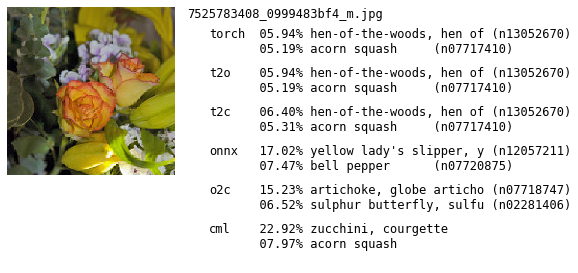

t2o - Most and Least Certain


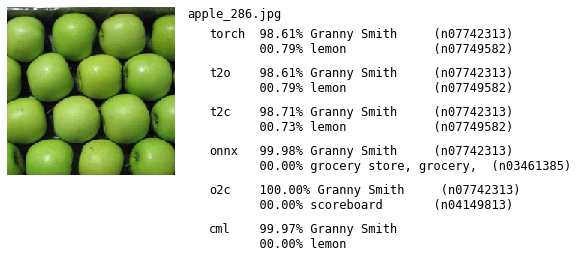

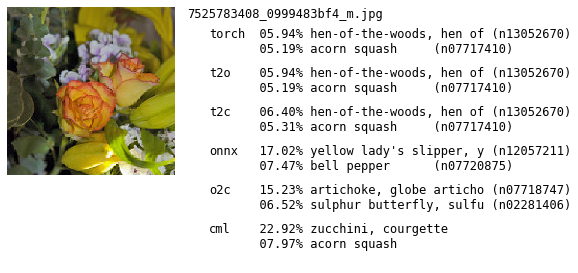

t2c - Most and Least Certain


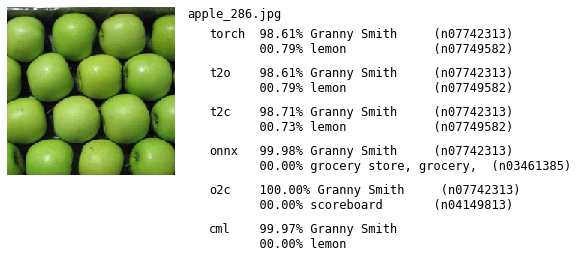

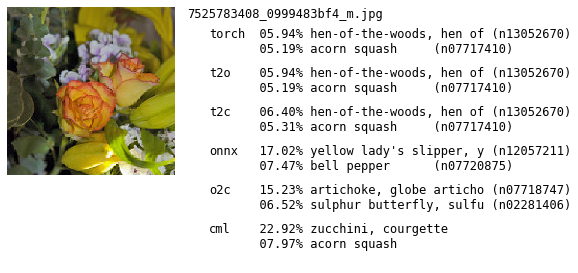

onnx - Most and Least Certain


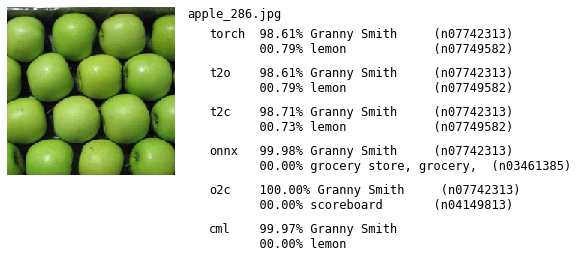

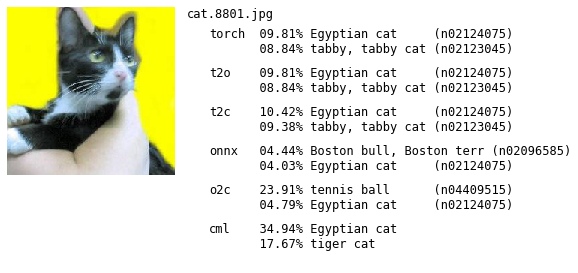

o2c - Most and Least Certain


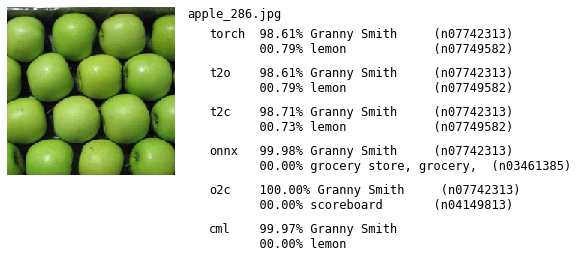

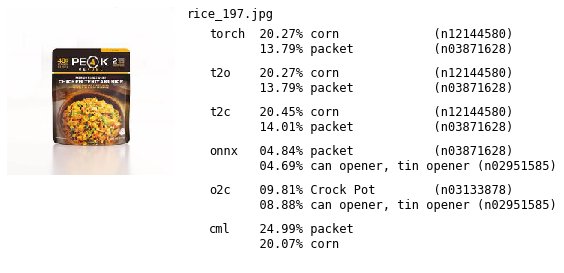

cml - Most and Least Certain


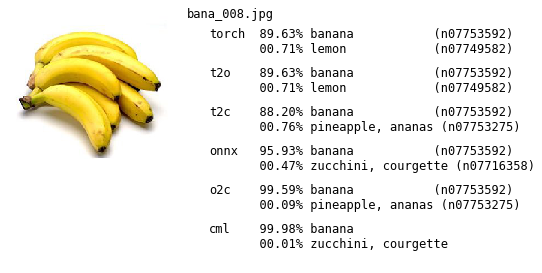

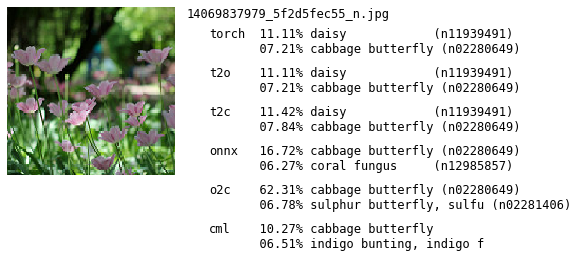

In [45]:
for i,ml in enumerate(results.most_least()):
    print(f"{results.i2m(i)} - Most and Least Certain")
    results.show(ml)

## Agreement?
How often does **T2C** agree with the other models? (A quick recap: T2C is the end result the *Torch->ONNX->CoreML* conversion path)

In [37]:
results.show_agreement('t2c')

t2c     and torch   agree on   94 of   96 or 97.92%
t2c     and t2o     agree on   94 of   96 or 97.92%
t2c     and t2c     agree on   96 of   96 or 100.00%
t2c     and onnx    agree on   54 of   96 or 56.25%
t2c     and o2c     agree on   45 of   96 or 46.88%
t2c     and cml     agree on   56 of   96 or 58.33%


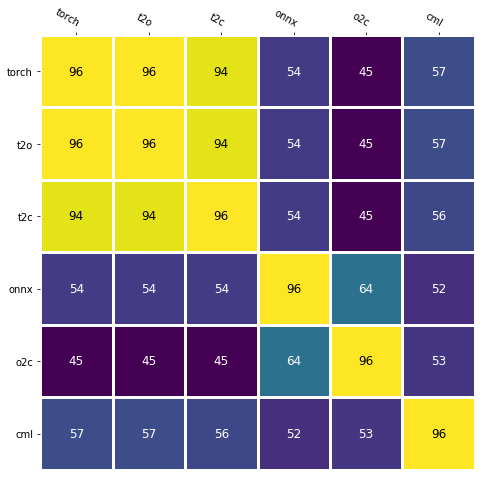

In [38]:
results.agree_matrix()

Allocate the 2 and 3 dim arrays we will need

The *Torch Family* (*Torch -> t2o -> t2c*) seems to produce very consistent results. Their predictions agree about 97% of the time. That is good news, because ultimately I'd like to port a Torch Resnet50 Model of my own creation to CoreML.

The *ONNX Family* agrees with itself only about 60% of the time. A little surprising, that. 

The native CoreML, ONNX and Torch models agree with each other %50 percent of the time.

## Agreement  - Best and Worst
How *well* does **T2C** agree with other models? To show the best and worst  differences between the predicted (top) probabilities for T2C and TORCH:

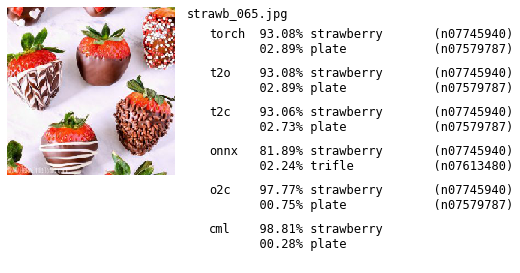

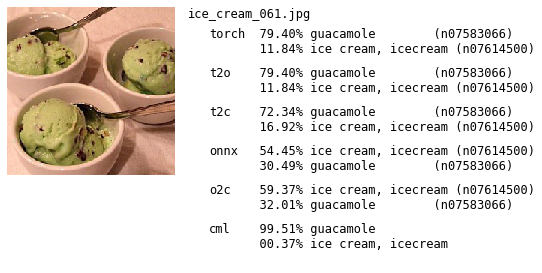

In [41]:
results.show(results.best_worst('t2c','torch'))

And for T2C and CML:

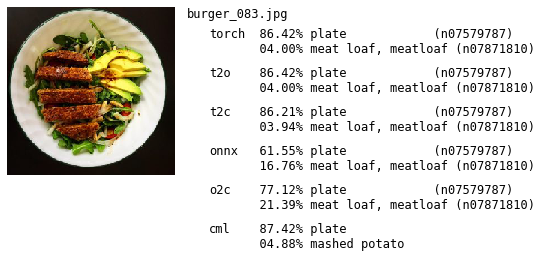

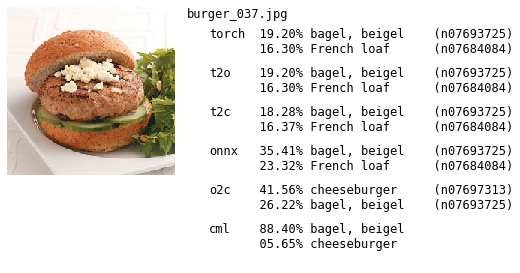

In [42]:
results.show(results.best_worst('t2c','cml'))

**Note for Future Work:** Selecting comparisons with a minimum difference is not quite enough. It would be useful to know if the predictions are *correct*. And we would like the prediction to have adequate *certainty*.

For example, if TORCH and T2C agree exactly, but the probability on which they agree is 2%, the prediction on which they are agreeing is likely to be wrong. So to get a better picture of Agreement Quality, we have to qualify the minimum differences by accuracy and certainty (probability).

*But I'll tackle that in the next round of comparison.  This notebook has gotten big enough!*

## Wrap Up - A Few More Result Pictures
Finally, to wrap up, here is another selection of images and their predictions


Showing results [7, 28, 36, 38, 51, 75, 76, 82] 
  and top 2 probabilities for each model


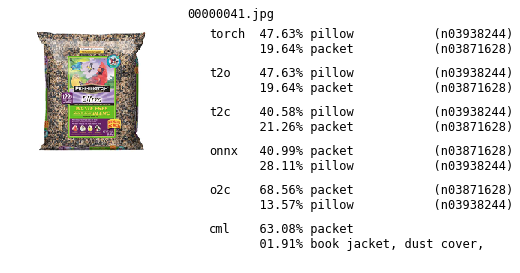

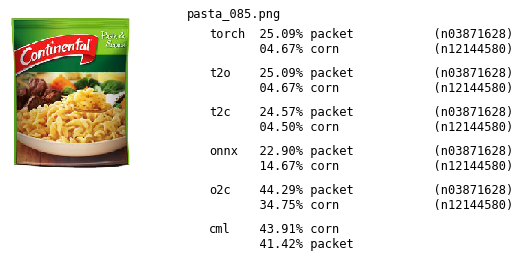

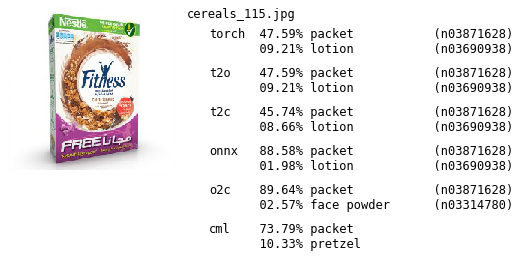

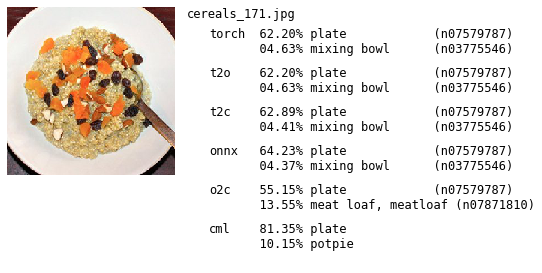

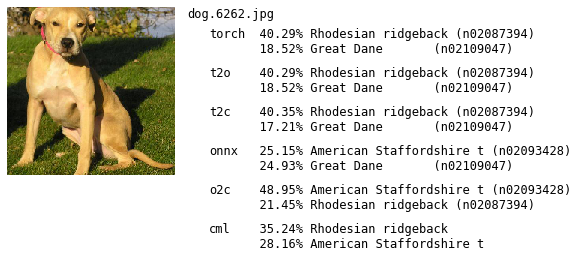

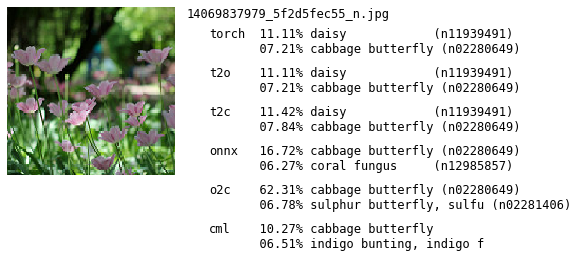

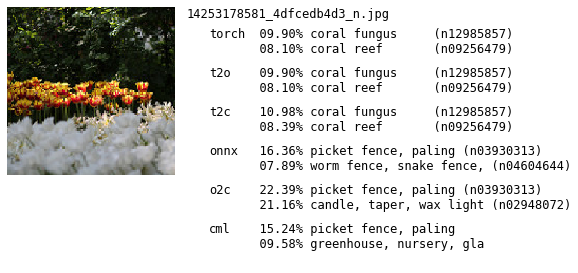

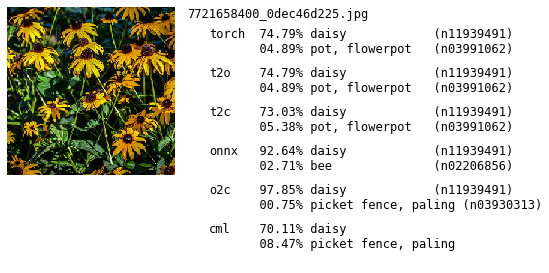

In [46]:
results.show_random(8)